In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from optuna.samplers import TPESampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression,ElasticNet
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge

from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# load the dataset
training_df = pd.read_excel('indices_df_d.xlsx')

training_df.head()

,DWSI,MSI,LWVI1,LWVI2,NDII,NDWI,WBI,NMDI,SD,SR,ND,MDATT,Water Potential (Mpa)
0,0.638643,0.619809,0.012191,0.036253,0.207077,0.045833,0.966546,0.470443,0.0010,1.015304,0.007594,-18.755556,-0.089632
1,0.834900,0.621971,0.007679,0.034491,0.205956,0.045102,0.971001,0.491520,-0.0005,1.013862,0.006883,-19.564103,-0.148237
2,0.880338,0.619670,0.010875,0.034380,0.208122,0.043521,0.969639,0.464310,0.0003,1.014173,0.007037,-19.000000,-0.128243
3,0.877961,0.599918,0.013940,0.040439,0.218082,0.042208,0.971235,0.462263,-0.0008,1.014815,0.007353,-19.826087,-0.164785
4,1.190506,0.566488,0.012489,0.043199,0.246819,0.051212,0.964867,0.476835,-0.0002,1.014706,0.007299,-18.636364,-0.326122


In [3]:
# ---------------------------------
# Define predictors and target
# ---------------------------------
X = training_df.drop(columns = ['Water Potential (Mpa)'])
y = training_df['Water Potential (Mpa)']

In [4]:
# Feature scaling
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Splitting the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# <font color = Orange> Multiple Linear Regression - PLSR

In [5]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for n_components to be integers between 1 and the number of features
    n_components = trial.suggest_int('n_components', 1, X_train.shape[1])
    # Set the range for max_iter to be between 100 and 1000
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    # Create the PLSR model with the specified hyperparameters
    model = PLSRegression(n_components=n_components, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_plsr = PLSRegression(n_components=trial.params['n_components'], max_iter=trial.params['max_iter'])

# Fit the model
best_plsr.fit(X_train, y_train)

# Make predictions
y_pred = best_plsr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 09:23:35,387] A new study created in memory with name: no-name-5e84e0b1-265d-44d1-af8b-c551ab86790f
[I 2024-03-07 09:23:35,418] Trial 0 finished with value: 8.14462823712326 and parameters: {'n_components': 12, 'max_iter': 518}. Best is trial 0 with value: 8.14462823712326.
[I 2024-03-07 09:23:35,434] Trial 1 finished with value: 2.153881680951556 and parameters: {'n_components': 3, 'max_iter': 624}. Best is trial 1 with value: 2.153881680951556.
[I 2024-03-07 09:23:35,446] Trial 2 finished with value: 2.1867891584212455 and parameters: {'n_components': 8, 'max_iter': 716}. Best is trial 1 with value: 2.153881680951556.
[I 2024-03-07 09:23:35,459] Trial 3 finished with value: 2.128514145701228 and parameters: {'n_components': 2, 'max_iter': 771}. Best is trial 3 with value: 2.128514145701228.
[I 2024-03-07 09:23:35,470] Trial 4 finished with value: 1.8704298818670158 and parameters: {'n_components': 4, 'max_iter': 778}. Best is trial 4 with value: 1.8704298818670158.
[I 2

[I 2024-03-07 09:23:37,139] Trial 46 finished with value: 1.9286000360507873 and parameters: {'n_components': 6, 'max_iter': 102}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:37,208] Trial 47 finished with value: 2.1867891584212455 and parameters: {'n_components': 8, 'max_iter': 200}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:37,276] Trial 48 finished with value: 1.6944016396496986 and parameters: {'n_components': 10, 'max_iter': 283}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:37,335] Trial 49 finished with value: 1.9695654791193717 and parameters: {'n_components': 7, 'max_iter': 349}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:37,369] Trial 50 finished with value: 1.7679276501537284 and parameters: {'n_components': 5, 'max_iter': 839}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:37,406] Trial 51 finished with value: 1.618670102976284 and parameters: {'n_components': 

[I 2024-03-07 09:23:38,598] Trial 93 finished with value: 2.128514145701228 and parameters: {'n_components': 2, 'max_iter': 115}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:38,622] Trial 94 finished with value: 1.618670102976284 and parameters: {'n_components': 9, 'max_iter': 554}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:38,646] Trial 95 finished with value: 1.6944016396496986 and parameters: {'n_components': 10, 'max_iter': 281}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:38,673] Trial 96 finished with value: 2.1867891584212455 and parameters: {'n_components': 8, 'max_iter': 836}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:38,697] Trial 97 finished with value: 1.7974797438355383 and parameters: {'n_components': 11, 'max_iter': 596}. Best is trial 9 with value: 1.618670102976284.
[I 2024-03-07 09:23:38,721] Trial 98 finished with value: 1.6944016396496986 and parameters: {'n_components': 

Number of finished trials:  100
Best trial:
  Value: 1.618670102976284
  Params: 
    n_components: 9
    max_iter: 937
Mean Squared Error: 1.618670102976284
Root Mean Squared Error: 1.2722696659813453
R-Squared value: 0.5979027445759956


In [6]:
# Get the coefficients from the trained PLSRegression model
coefficients = best_plsr.coef_.flatten()

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")

Top 3 Features:
MSI: 2.597192695734578
NDII: 1.7207629440654941
NDWI: 0.743945950253757


# <font color = Blue> Elastic Net

In [7]:
# Tune the hyperparameters using Optuna
def objective(trial):
    
    # Set the range for alpha to be uniform between 0.0 and 1.0, alpha is the regularization parameter
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for l1_ratio to be uniform between 0.0 and 1.0, l1_ratio is the ElasticNet mixing parameter
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    # Set the range for max_iter to be between 100 and 1000, max_iter is the maximum number of iterations
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    # Create the ElasticNet model with the specified hyperparameters
    model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=max_iter)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    # Return mse as the objective value
    return mse

# Create the Optuna study, we maximize the objective function (the score)
# model.score() returns the coefficient of determination R^2 of the prediction 
# i.e. the percentage of the variance in the target variable that is predictable from the feature variables
study = optuna.create_study(direction='minimize', sampler = TPESampler(seed=37))
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial

# Print the value of the final trial and the best parameters
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_elastic_net = ElasticNet(alpha=study.best_params['alpha'], l1_ratio=study.best_params['l1_ratio'], max_iter=study.best_params['max_iter'])

# Fit the model
best_elastic_net.fit(X_train, y_train)

# Make predictions
y_pred = best_elastic_net.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 09:23:38,794] A new study created in memory with name: no-name-94f1e5b7-853a-4859-a3d2-8ddefd397375
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:38,799] Trial 0 finished with value: 4.422159743366444 and parameters: {'alpha': 0.9444966028573069, 'l1_ratio': 0.4640981743044076, 'max_iter': 273}. Best is trial 0 with value: 4.422159743366444.
/var/folders/3h/631y9g

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:38,861] Trial 10 finished with value: 2.3001908773128323 and parameters: {'alpha': 0.27682391622961355, 'l1_ratio': 0.06343733200190918, 'max_iter': 457}. Best is trial 7 with value: 2.1715527584290224.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-03-07 09:23:39,046] Trial 19 finished with value: 1.988318486155756 and parameters: {'alpha': 0.030293406542614122, 'l1_ratio': 0.41301718809827204, 'max_iter': 775}. Best is trial 13 with value: 1.915175403895143.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:39,067] Trial 20 finished with value: 3.7983643814178962 and parameters: {'alpha': 0.6004871088890619, 'l1_rati

[I 2024-03-07 09:23:39,322] Trial 29 finished with value: 4.573766545135173 and parameters: {'alpha': 0.9668894200089733, 'l1_ratio': 0.48034521188901147, 'max_iter': 874}. Best is trial 21 with value: 1.890243982629723.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:39,350] Trial 30 finished with value: 2.2603618787189035 and parameters: {'alpha': 0.08822521531676446, 'l1_ratio

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:39,728] Trial 39 finished with value: 2.198943912340949 and parameters: {'alpha': 0.08684693858106529, 'l1_ratio': 0.44992799147224366, 'max_iter': 907}. Best is trial 31 with value: 1.8133502826302001.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.742e+00, tolerance: 6.230e-03
  model = cd_fast.enet_coordinat

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:40,470] Trial 56 finished with value: 2.256776982434364 and parameters: {'alpha': 0.06261559295992916, 'l1_ratio': 0.9654431997205292, 'max_iter': 491}. Best is trial 31 with value: 1.8133502826302001.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:40,908] Trial 65 finished with value: 2.291292242824714 and parameters: {'alpha': 0.08075903059292353, 'l1_ratio': 0.8321719802667383, 'max_iter': 292}. Best is trial 31 with value: 1.8133502826302001.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:41,416] Trial 74 finished with value: 2.0851682483950293 and parameters: {'alpha': 0.03518599060427644, 'l1_ratio': 0.8560452537724831, 'max_iter': 433}. Best is trial 31 with value: 1.8133502826302001.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecate

[I 2024-03-07 09:23:41,750] Trial 83 finished with value: 2.2658769316821656 and parameters: {'alpha': 0.07498699313185408, 'l1_ratio': 0.8001012551387188, 'max_iter': 343}. Best is trial 31 with value: 1.8133502826302001.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
[I 2024-03-07 09:23:41,778] Trial 84 finished with value: 2.1361352337465296 and parameters: {'alpha': 0.057539683168403556, 'l1_ra

[I 2024-03-07 09:23:42,066] Trial 92 finished with value: 1.9786277718896474 and parameters: {'alpha': 0.021475951202705162, 'l1_ratio': 0.7258242668285674, 'max_iter': 360}. Best is trial 31 with value: 1.8133502826302001.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/3317287144.py:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
/Users/trangtran/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objec

Number of finished trials:  100
Best trial:
  Value: 1.8133502826302001
  Params: 
    alpha: 0.0003407863048102387
    l1_ratio: 0.4455245309336924
    max_iter: 591
Mean Squared Error: 1.8133502826302001
Root Mean Squared Error: 1.346606951797814
R-Squared value: 0.5495418304030852


In [8]:
# Get the coefficients from the trained ElasticNet model
coefficients = best_elastic_net.coef_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, coefficients))

# Sort the features by absolute coefficient values
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: abs(x[1]), reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, coefficient in sorted_features[:top_n]:
    print(f"{feature}: {coefficient}")


Top 3 Features:
MSI: 3.268363774064022
NDII: 2.2769144155513596
SR: 1.2339467672325684


# <font color = Red> Non-linear Kernel Ridge Regression (KRR)

In [9]:
# Define the objective function for Optuna
def objective(trial):
    # Set the range for alpha to be uniform between 0.0 and 1.0
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    # Set the range for gamma to be loguniform between 1e-6 and 1e6
    gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
    # Set the range for kernel to be categorical between 'linear' and 'rbf'
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf'])
    
    # Create the Kernel Ridge Regression model with the specified hyperparameters
    model = KernelRidge(alpha=alpha, gamma=gamma, kernel=kernel)
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = metrics.mean_squared_error(y_test, model.predict(X_test))
    
    # Return mse as the objective value
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the number of finished trials
print("Number of finished trials: ", len(study.trials))

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the model using the best parameters
best_krr = KernelRidge(alpha=trial.params['alpha'], gamma=trial.params['gamma'], kernel=trial.params['kernel'])

# Fit the model
best_krr.fit(X_train, y_train)

# Make predictions
y_pred = best_krr.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 09:23:42,546] A new study created in memory with name: no-name-2f0ddb46-451c-4398-97f6-eeaa95ec65ef
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:42,604] Trial 0 finished with value: 9.147964190722606 and parameters: {'alpha': 0.9444966028573069, 'gamma': 0.3708327584362581, 'kernel': 'rbf'}. Best is trial 0 with value: 9.147964190722606.
/var/folder

[I 2024-03-07 09:23:42,778] Trial 9 finished with value: 7.074528678856244 and parameters: {'alpha': 0.6402713827422477, 'gamma': 1.6968526427052133e-06, 'kernel': 'linear'}. Best is trial 5 with value: 4.593858361176889.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:42,839] Trial 10 finished with value: 3.6893519355465774 and parameters: {'alpha': 0.0039159496409

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:43,131] Trial 20 finished with value: 3.5012581912395455 and parameters: {'alpha': 0.09214436620061181, 'gamma': 0.00025032987492113016, 'kernel': 'rbf'}. Best is trial 12 with value: 2.352241409995034.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has b

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:43,428] Trial 29 finished with value: 9.435276895561435 and parameters: {'alpha': 0.9668894200089733, 'gamma': 0.4832382670869172, 'kernel': 'rbf'}. Best is trial 12 with value: 2.352241409995034.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been

[I 2024-03-07 09:23:43,758] Trial 38 finished with value: 7.047208317243283 and parameters: {'alpha': 0.8603166234018824, 'gamma': 7.005364451379893e-05, 'kernel': 'linear'}. Best is trial 34 with value: 2.203372835668534.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:43,776] Trial 39 finished with value: 7.210302835058207 and parameters: {'alpha': 0.0471777114684

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:44,086] Trial 49 finished with value: 6.069027811577488 and parameters: {'alpha': 0.09395454097590822, 'gamma': 1.0203520694914814e-06, 'kernel': 'rbf'}. Best is trial 34 with value: 2.203372835668534.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has be

[I 2024-03-07 09:23:44,333] Trial 58 finished with value: 7.058539089213665 and parameters: {'alpha': 0.007211702741803626, 'gamma': 0.00010815875708486042, 'kernel': 'linear'}. Best is trial 56 with value: 2.1743113732377988.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:44,356] Trial 59 finished with value: 3.9382090858281966 and parameters: {'alpha': 0.10803418

[I 2024-03-07 09:23:44,563] Trial 68 finished with value: 4.991168301694759 and parameters: {'alpha': 0.6519976785379826, 'gamma': 0.00038066378528875676, 'kernel': 'rbf'}. Best is trial 65 with value: 2.1196660749006875.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:44,594] Trial 69 finished with value: 4.331447238493046 and parameters: {'alpha': 0.05707436413531

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:44,843] Trial 78 finished with value: 2.4419566257536496 and parameters: {'alpha': 0.07354757656491864, 'gamma': 0.001640171178089442, 'kernel': 'rbf'}. Best is trial 65 with value: 2.1196660749006875.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has

[I 2024-03-07 09:23:45,094] Trial 87 finished with value: 7.040986582891659 and parameters: {'alpha': 0.9145347108661824, 'gamma': 0.20997717775880737, 'kernel': 'linear'}. Best is trial 65 with value: 2.1196660749006875.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:45,134] Trial 88 finished with value: 2.990898119984516 and parameters: {'alpha': 0.05299515143265

[I 2024-03-07 09:23:45,356] Trial 97 finished with value: 3.5778307498483612 and parameters: {'alpha': 0.11485645040392078, 'gamma': 0.0002872019257302251, 'kernel': 'rbf'}. Best is trial 65 with value: 2.1196660749006875.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:4: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/295769073.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  gamma = trial.suggest_loguniform('gamma', 1e-6, 1e6)
[I 2024-03-07 09:23:45,384] Trial 98 finished with value: 2.0603561784479782 and parameters: {'alpha': 0.000344141939

Number of finished trials:  100
Best trial:
  Value: 2.0603561784479782
  Params: 
    alpha: 0.0003441419395103715
    gamma: 0.004786756094563859
    kernel: rbf
Mean Squared Error: 2.0603561784479782
Root Mean Squared Error: 1.435394084719586
R-Squared value: 0.4881825746787387


In [10]:
# Get the dual coefficients from the trained KernelRidge model
coefficients = best_krr.dual_coef_

# Calculate the squared magnitude of coefficients (as they are signed)
squared_magnitude = np.abs(coefficients) ** 2

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature coefficients with their corresponding names
feature_coefficients_dict = dict(zip(feature_names, squared_magnitude))

# Sort the features by their squared magnitude (importance)
sorted_features = sorted(feature_coefficients_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their coefficients
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, magnitude in sorted_features[:top_n]:
    print(f"{feature}: {magnitude}")


Top 3 Features:
LWVI2: 3359348.5292332
ND: 1526876.3190962288
NDWI: 880173.9297509535


# Principal Component Regression (PCR)

Number of components that explain at least 95% of the variance: 1


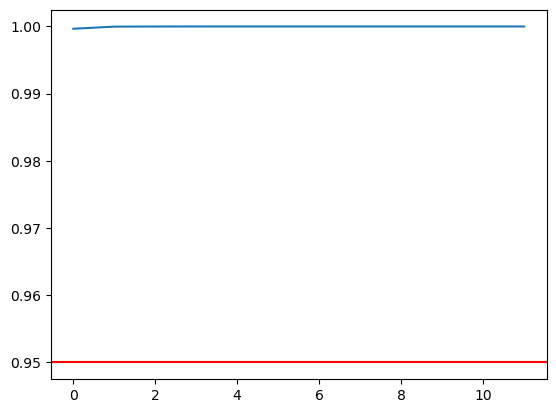

In [11]:
# Create an instance of PCA
pca = PCA(random_state= 37)

# Perform PCA on the predictors DataFrame
pca.fit(X)

# Calculate the cumulative sum of the explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the cumulative explained variance with a vertical line at 95%
plt.plot(cumulative_explained_variance)
plt.axhline(y=0.95, color='r', linestyle='-')

# Find the number of components that explain at least 95% of the variance
pca_n_components = np.where(cumulative_explained_variance >= 0.95)[0][0] + 1

print(f'Number of components that explain at least 95% of the variance: {pca_n_components}')

In [12]:
# Define the number of principal components to retain
n_components = pca_n_components

# Create a pipeline with PCA and Linear Regression
pipeline = make_pipeline(PCA(n_components), LinearRegression())

# Fit the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 2.4129303678988725
Root Mean Squared Error: 1.5533609908514094
R-Squared value: 0.4005988764002115


In [13]:
# Get the principal components from the trained PCA model within the pipeline
principal_components = pipeline.named_steps['pca'].components_

# Calculate the squared loadings of each feature on the principal components
squared_loadings = principal_components ** 2

# Sum the squared loadings across principal components to get feature importance
feature_importance = squared_loadings.sum(axis=0)

# Get the names of the original features
feature_names = X.columns

# Create a dictionary to store feature importance with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importance))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
WBI: 0.12337560202968917
MSI: 0.11508678906840777
LWVI2: 0.11404354724339714


# <font color = Purple> Ensemble Methods

## <font color = darkgreen> Random Forest Regression

In [14]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    # Create the Random Forest model with the specified hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split, 
        min_samples_leaf=min_samples_leaf
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Random Forest model using the best parameters
best_rf_model = RandomForestRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    min_samples_split=trial.params['min_samples_split'], 
    min_samples_leaf=trial.params['min_samples_leaf']
)

# Fit the model
best_rf_model.fit(X_train, y_train)

# Make predictions
y_pred = best_rf_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-07 09:23:46,025] A new study created in memory with name: no-name-b8054648-82b1-4d06-9b47-580fcd3426cc
[I 2024-03-07 09:23:46,467] Trial 0 finished with value: 3.045773824868361 and parameters: {'n_estimators': 145, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 6}. Best is trial 0 with value: 3.045773824868361.
[I 2024-03-07 09:23:46,621] Trial 1 finished with value: 3.698825312141102 and parameters: {'n_estimators': 112, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 8}. Best is trial 0 with value: 3.045773824868361.
[I 2024-03-07 09:23:46,734] Trial 2 finished with value: 3.114563844979896 and parameters: {'n_estimators': 78, 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 3.045773824868361.
[I 2024-03-07 09:23:46,872] Trial 3 finished with value: 2.0827981954716552 and parameters: {'n_estimators': 94, 'max_depth': 30, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 3 with value: 2.08

[I 2024-03-07 09:23:53,436] Trial 36 finished with value: 3.466443818962242 and parameters: {'n_estimators': 116, 'max_depth': 9, 'min_samples_split': 15, 'min_samples_leaf': 7}. Best is trial 12 with value: 1.9039360637153386.
[I 2024-03-07 09:23:53,640] Trial 37 finished with value: 2.997375109625478 and parameters: {'n_estimators': 130, 'max_depth': 23, 'min_samples_split': 12, 'min_samples_leaf': 5}. Best is trial 12 with value: 1.9039360637153386.
[I 2024-03-07 09:23:53,744] Trial 38 finished with value: 2.2073708776130734 and parameters: {'n_estimators': 50, 'max_depth': 19, 'min_samples_split': 17, 'min_samples_leaf': 1}. Best is trial 12 with value: 1.9039360637153386.
[I 2024-03-07 09:23:53,895] Trial 39 finished with value: 2.284889786530526 and parameters: {'n_estimators': 84, 'max_depth': 27, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 12 with value: 1.9039360637153386.
[I 2024-03-07 09:23:54,077] Trial 40 finished with value: 3.734524298215008 and parame

[I 2024-03-07 09:23:59,899] Trial 72 finished with value: 2.5884513389554082 and parameters: {'n_estimators': 58, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 68 with value: 1.8747802247539258.
[I 2024-03-07 09:24:00,039] Trial 73 finished with value: 1.9330939022523517 and parameters: {'n_estimators': 71, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 68 with value: 1.8747802247539258.
[I 2024-03-07 09:24:00,180] Trial 74 finished with value: 2.270497137946532 and parameters: {'n_estimators': 70, 'max_depth': 26, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 68 with value: 1.8747802247539258.
[I 2024-03-07 09:24:00,301] Trial 75 finished with value: 2.151959792094832 and parameters: {'n_estimators': 61, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 68 with value: 1.8747802247539258.
[I 2024-03-07 09:24:00,404] Trial 76 finished with value: 2.3000424979643674 and parameter

Best trial:
  Value: 1.8747802247539258
  Params: 
    n_estimators: 71
    max_depth: 25
    min_samples_split: 8
    min_samples_leaf: 2
Mean Squared Error: 2.180886517410699
Root Mean Squared Error: 1.4767824881852774
R-Squared value: 0.4582413788766285


In [15]:
# Get feature importances from the trained RandomForestRegressor model
feature_importances = best_rf_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
SD: 0.34659200354538544
MDATT: 0.30949443133293103
SR: 0.11256952125688935


## <font color = darkgreen> Gradient Boosting Regression

In [16]:
# Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)  # Adjust the range for max_depth
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
    
    # Create the Gradient Boosting model with the specified hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate  # Pass learning_rate to the model
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the Gradient Boosting model using the best parameters
best_gb_model = GradientBoostingRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate']  # Pass learning_rate to the model
)

# Fit the model
best_gb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_gb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))


[I 2024-03-07 09:24:03,448] A new study created in memory with name: no-name-a9bde9db-3918-4574-ab02-2e961de92661
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:03,649] Trial 0 finished with value: 2.7442254856704267 and parameters: {'n_estimators': 145, 'max_depth': 6, 'learning_rate': 0.027351552606144185}. Best is trial 0 with value: 2.7442254856704267.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.sugg

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:05,161] Trial 14 finished with value: 2.4266452928615823 and parameters: {'n_estimators': 83, 'max_depth': 4, 'learning_rate': 0.09844522487099279}. Best is trial 10 with value: 2.092681517963068.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:05,281] Trial 15 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:06,626] Trial 28 finished with value: 2.2140502213810604 and parameters: {'n_estimators': 105, 'max_depth': 4, 'learning_rate': 0.06255808454329412}. Best is trial 26 with value: 1.9527084310038834.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:06,784] Trial 29 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:08,340] Trial 42 finished with value: 2.3739257306765156 and parameters: {'n_estimators': 140, 'max_depth': 3, 'learning_rate': 0.06548620452708283}. Best is trial 26 with value: 1.9527084310038834.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:08,475] Trial 43 

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:09,717] Trial 56 finished with value: 2.063427763386136 and parameters: {'n_estimators': 51, 'max_depth': 3, 'learning_rate': 0.08870677284320783}. Best is trial 51 with value: 1.7156064934915758.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:09,796] Trial 57 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:10,787] Trial 70 finished with value: 2.217893813657451 and parameters: {'n_estimators': 58, 'max_depth': 3, 'learning_rate': 0.08241744123365193}. Best is trial 57 with value: 1.658851920222532.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:10,860] Trial 71 fin

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:11,833] Trial 84 finished with value: 1.7994650289257612 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.08951892060311775}. Best is trial 57 with value: 1.658851920222532.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:11,918] Trial 85 fi

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:13,007] Trial 98 finished with value: 2.0954883868275886 and parameters: {'n_estimators': 52, 'max_depth': 3, 'learning_rate': 0.07791501560713891}. Best is trial 57 with value: 1.658851920222532.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_29364/517228355.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)  # Add learning_rate hyperparameter
[I 2024-03-07 09:24:13,088] Trial 99 fi

Best trial:
  Value: 1.658851920222532
  Params: 
    n_estimators: 65
    max_depth: 3
    learning_rate: 0.08959813846065505
Mean Squared Error: 1.7375393662036782
Root Mean Squared Error: 1.3181575650140154
R-Squared value: 0.5683741801019107


In [17]:
# Get feature importances from the trained GradientBoostingRegressor model
feature_importances = best_gb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")


Top 3 Features:
MDATT: 0.5749309099648683
SR: 0.07655084419745867
NDWI: 0.05790810072049125


## <font color = green> XGBoost

In [5]:
### Define the objective function for Optuna
def objective(trial):
    # Define the search space for hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 50, 150)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
    
    # Create the XGBoost model with the specified hyperparameters
    model = XGBRegressor(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree
    )
    
    # Fit the model to the training data
    model.fit(X_train, y_train)
    
    # Get the MSE of the model on the testing data
    mse = mean_squared_error(y_test, model.predict(X_test))
    
    # Return the MSE as the objective value to minimize
    return mse

# Create the Optuna study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=37))

# Optimize the objective function
study.optimize(objective, n_trials=100)

# Print the best trial and save as a variable
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
# Create the XGBoost model using the best parameters
best_xgb_model = XGBRegressor(
    n_estimators=trial.params['n_estimators'], 
    max_depth=trial.params['max_depth'], 
    learning_rate=trial.params['learning_rate'],
    min_child_weight=trial.params['min_child_weight'],
    subsample=trial.params['subsample'],
    colsample_bytree=trial.params['colsample_bytree']
)

# Fit the model
best_xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = best_xgb_model.predict(X_test)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

[I 2024-03-08 09:38:40,441] A new study created in memory with name: no-name-69027144-a140-4068-865a-2f781ea10fcf
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/

[I 2024-03-08 09:42:54,072] Trial 6 finished with value: 1.850862948527827 and parameters: {'n_estimators': 114, 'max_depth': 3, 'learning_rate': 0.08254345345232203, 'min_child_weight': 5, 'subsample': 0.5018019421849012, 'colsample_bytree': 0.7326167078381765}. Best is trial 6 with value: 1.850862948527827.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-08 09:49:28,191] Trial 19 finished with value: 1.0220574816921075 and parameters: {'n_estimators': 137, 'max_depth': 3, 'learning_rate': 0.06255808454329412, 'min_child_weight': 7, 'subsample': 0.9408658689201809, 'colsample_bytree': 0.6606708598744264}. Best is trial 16 with value: 0.992757667730273.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5, 1.0)
[I 2024-03-08 09:56:56,836] Trial 32 finished with value: 2.2086243186432655 and parameters: {'n_estimators': 143, 'max_depth': 4, 'learning_rate': 0.07866726826580146, 'min_child_weight': 8, 'subsample': 0.8702545026353576, 'colsample_bytree': 0.7067533863696214}. Best is trial 22 with value: 0.8986149558140119.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/f

[I 2024-03-08 10:00:11,286] Trial 38 finished with value: 1.1412543137879032 and parameters: {'n_estimators': 87, 'max_depth': 6, 'learning_rate': 0.09328622243714128, 'min_child_weight': 6, 'subsample': 0.8921285214999775, 'colsample_bytree': 0.8284832204393825}. Best is trial 22 with value: 0.8986149558140119.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-08 10:08:06,030] Trial 51 finished with value: 0.9526205291962416 and parameters: {'n_estimators': 138, 'max_depth': 3, 'learning_rate': 0.08195137626964484, 'min_child_weight': 5, 'subsample': 0.8858271150597075, 'colsample_bytree': 0.7984095079503789}. Best is trial 22 with value: 0.8986149558140119.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-08 10:15:56,520] Trial 64 finished with value: 0.8311063500417779 and parameters: {'n_estimators': 142, 'max_depth': 3, 'learning_rate': 0.09094523889161332, 'min_child_weight': 6, 'subsample': 0.8634763117359662, 'colsample_bytree': 0.8232477976661438}. Best is trial 64 with value: 0.8311063500417779.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-08 10:27:09,620] Trial 77 finished with value: 0.7968636639071408 and parameters: {'n_estimators': 145, 'max_depth': 8, 'learning_rate': 0.09570543934663552, 'min_child_weight': 5, 'subsample': 0.843808516343038, 'colsample_bytree': 0.8722086373444475}. Best is trial 70 with value: 0.7169051775722538.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

[I 2024-03-08 10:32:46,131] Trial 90 finished with value: 0.8794794242172886 and parameters: {'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.09205478211059043, 'min_child_weight': 5, 'subsample': 0.8223016291504521, 'colsample_bytree': 0.9305198232575773}. Best is trial 70 with value: 0.7169051775722538.
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y

/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  learning_rate = trial.suggest_uniform('learning_rate', 0.01, 0.1)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
/var/folders/3h/631y9grn15xf3n6ybqs6vrp40000gn/T/ipykernel_41371/2501454849.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.5

Best trial:
  Value: 0.7169051775722538
  Params: 
    n_estimators: 147
    max_depth: 7
    learning_rate: 0.09579973204971293
    min_child_weight: 5
    subsample: 0.7901086068748324
    colsample_bytree: 0.8689505335714756
Mean Squared Error: 0.7169051775722538
Root Mean Squared Error: 0.8467025319273905
R-Squared value: 0.8219120722801876


In [6]:
# Get feature importances from the trained XGBoost model
feature_importances = best_xgb_model.feature_importances_

# Get the names of the features
feature_names = X.columns

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort the features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores
top_n = 3  # specify the number of top features you want to display
print(f"Top {top_n} Features:")
for feature, importance in sorted_features[:top_n]:
    print(f"{feature}: {importance}")

Top 3 Features:
SR: 0.22005298733711243
SD: 0.18895678222179413
WBI: 0.111489437520504


In [8]:
# Add Gaussian Noise
noise_mean = 0
noise_std = 0.01 # Adjust the standard deviation for the Gaussian noise

# Generate Gaussian noise with the same shape as your input features
gaussian_noise_train = np.random.normal(noise_mean, noise_std, X_train.shape)
gaussian_noise_test = np.random.normal(noise_mean, noise_std, X_test.shape)

# Add the noise to the training and testing data
X_train_noisy = X_train + gaussian_noise_train
X_test_noisy = X_test + gaussian_noise_test

# Retrain the Model
best_xgb_model.fit(X_train_noisy, y_train)

# Evaluate Changes in Top Predictors
# Get feature importances from the retrained model
feature_importances_noisy = best_xgb_model.feature_importances_

# Create a dictionary to store feature importance scores with their corresponding names
feature_importance_dict_noisy = dict(zip(feature_names, feature_importances_noisy))

# Sort the features by importance
sorted_features_noisy = sorted(feature_importance_dict_noisy.items(), key=lambda x: x[1], reverse=True)

# Print the top N features and their importance scores for the noisy dataset
print(f"Top {top_n} Features with Gaussian Noise:")
for feature, importance in sorted_features_noisy[:top_n]:
    print(f"{feature}: {importance}")

# Repeat the process with different levels of Gaussian noise for a more robust analysis

# Compute Sensitivity Metric
# Here, you can compute a sensitivity metric using the changes in top predictors between the original and noisy datasets.
# For example, you can calculate the average absolute difference in feature importance scores.

# Initialize a list to store the absolute differences in feature importance scores
absolute_differences = []

# Compute the absolute differences in feature importance scores between the original and noisy datasets
for (feature, importance), (feature_noisy, importance_noisy) in zip(sorted_features, sorted_features_noisy):
    absolute_difference = abs(importance - importance_noisy)
    absolute_differences.append(absolute_difference)

# Compute the average absolute difference
average_absolute_difference = np.mean(absolute_differences)
print(f"Average Absolute Difference in Feature Importance: {average_absolute_difference}")

Top 3 Features with Gaussian Noise:
SR: 0.254181444644928
SD: 0.22369137406349182
MDATT: 0.13917061686515808
Average Absolute Difference in Feature Importance: 0.01712988130748272


In [9]:
# Make predictions
y_pred = best_xgb_model.predict(X_test_noisy)

# Model Evaluation
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
print('R-Squared value:', r2_score(y_test, y_pred))

Mean Squared Error: 0.6788479383337127
Root Mean Squared Error: 0.8239222890137836
R-Squared value: 0.8313659513743246
